# Homework 2, *part 2* (60 points)

In this assignment you will build a heavy convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
%cd /content/gdrive/My Drive/net
%ls


/content/gdrive/My Drive/net
homework_part_2.ipynb  tiny_imagenet.py


## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the validation set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision
%matplotlib inline

In [8]:
import tiny_imagenet
tiny_imagenet.download(".")

Dataset not exists or is broken, downloading it


Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [0]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset, val_dataset = torch.utils.data.random_split(val_dataset, [10000, 10000])

In [0]:
batch_size = 50
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      

In [0]:
model = nn.Sequential()

#decribe convnet here
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding = (1, 1)))
model.add_module('norm1',nn.BatchNorm2d(64))
model.add_module('relu1', nn.ReLU())

model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = (1, 1)))
model.add_module('relu2', nn.ReLU())
model.add_module('norm2',nn.BatchNorm2d(64))
model.add_module('pool1', nn.MaxPool2d(2))



model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = (1, 1)))
model.add_module('norm3',nn.BatchNorm2d(128))
model.add_module('relu3', nn.ReLU())

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = (1, 1)))
model.add_module('norm4',nn.BatchNorm2d(128))
model.add_module('relu4', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))



model.add_module('conv5', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = (1, 1)))
model.add_module('norm5',nn.BatchNorm2d(256))
model.add_module('relu5', nn.ReLU())

model.add_module('conv6', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = (1, 1)))
model.add_module('norm6',nn.BatchNorm2d(256))
model.add_module('relu6', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(2))


model.add_module('conv7', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = (1, 1)))
model.add_module('norm7',nn.BatchNorm2d(512))
model.add_module('relu7', nn.ReLU())

model.add_module('conv8', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = (1, 1)))
model.add_module('norm8',nn.BatchNorm2d(512))
model.add_module('relu8', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(2))

model.add_module('flat', Flatten())
model.add_module('linear', nn.Linear(8192, 1024))
model.add_module('relu7', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.5))

model.add_module('dense1_logits', nn.Linear(1024, 200))

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
import numpy as np
import time
from tqdm import tqdm

In [33]:
#code form seminar
opt = torch.optim.Adam(model.parameters(), lr = 1e-4)

train_loss = []
val_accuracy = []

num_epochs = 10 # total amount of full passes over training data

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    print(epoch)    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))



  0%|          | 0/10 [00:00<?, ?it/s]

0




 10%|█         | 1/10 [03:13<29:01, 193.52s/it]

Epoch 1 of 10 took 193.519s
  training loss (in-iteration): 	4.311923
  validation accuracy: 			18.82 %
1




 20%|██        | 2/10 [06:27<25:48, 193.58s/it]

Epoch 2 of 10 took 193.702s
  training loss (in-iteration): 	3.475576
  validation accuracy: 			27.25 %
2




 30%|███       | 3/10 [09:40<22:33, 193.39s/it]

Epoch 3 of 10 took 192.935s
  training loss (in-iteration): 	3.058631
  validation accuracy: 			32.28 %
3




 40%|████      | 4/10 [12:53<19:19, 193.32s/it]

Epoch 4 of 10 took 193.138s
  training loss (in-iteration): 	2.752942
  validation accuracy: 			35.92 %
4




 50%|█████     | 5/10 [16:09<16:11, 194.30s/it]

Epoch 5 of 10 took 196.573s
  training loss (in-iteration): 	2.494204
  validation accuracy: 			36.41 %
5




 60%|██████    | 6/10 [19:24<12:57, 194.46s/it]

Epoch 6 of 10 took 194.829s
  training loss (in-iteration): 	2.265214
  validation accuracy: 			38.64 %
6




 70%|███████   | 7/10 [22:38<09:42, 194.16s/it]

Epoch 7 of 10 took 193.446s
  training loss (in-iteration): 	2.046828
  validation accuracy: 			41.42 %
7




 80%|████████  | 8/10 [25:51<06:27, 193.94s/it]

Epoch 8 of 10 took 193.420s
  training loss (in-iteration): 	1.832201
  validation accuracy: 			41.30 %
8




 90%|█████████ | 9/10 [29:04<03:13, 193.71s/it]

Epoch 9 of 10 took 193.177s
  training loss (in-iteration): 	1.616093
  validation accuracy: 			41.44 %
9




100%|██████████| 10/10 [32:18<00:00, 193.63s/it]



Epoch 10 of 10 took 193.422s
  training loss (in-iteration): 	1.392284
  validation accuracy: 			41.62 %


In [35]:
torch.save(model, 'model_VGG__1')
torch.save(model.state_dict(), 'params_model_VGG__1')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Text(0, 0.5, 'loss')

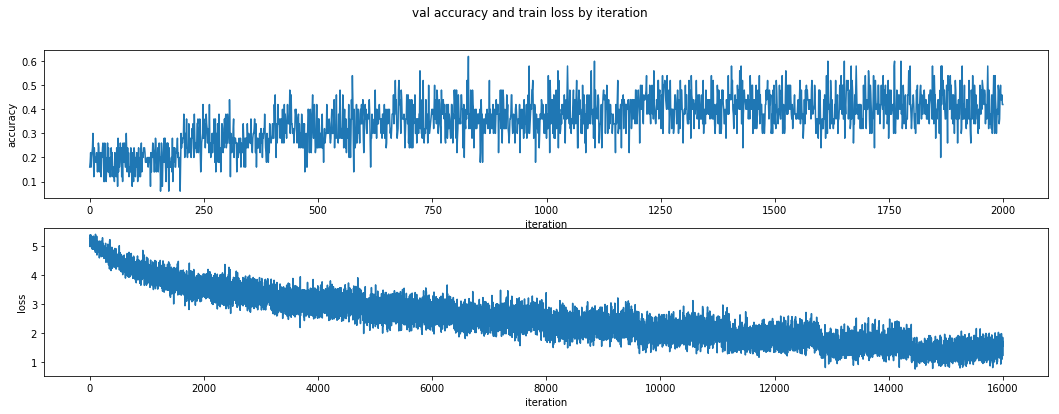

In [36]:
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.suptitle("val accuracy and train loss by iteration")
plt.plot(val_accuracy)
plt.xlabel('iteration')
plt.ylabel('accuracy')

plt.subplot(212)

plt.plot(train_loss)
plt.xlabel('iteration')
plt.ylabel('loss')

When everything is done, lets check model on test dataset.

In [0]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [40]:
acc=[]
model.train(False) # disable dropout / use averages for batch_norm
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    # Then we print the results for this epoch:
#     print("Epoch {} of {} took {:.3f}s".format(
#         epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss (in-iteration): \t{:.6f}".format(
#         np.mean(train_loss[-len(train_dataset) // batch_size :])))
print("  test accuracy: \t\t\t{:.2f} %".format(np.mean(acc[-len(test_dataset) // batch_size :]) * 100))

  test accuracy: 			41.21 %


# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

My first decision was try code from seminar by week 2 and I used some of code like a basis. The first try was unseccesfull my val. accuracy was only 9%. After thet I decided just add some conv layes, I used such architecture: *Conv(3,64) Relu maxpool(2),Conv(64,128) ReLU() maxpool(2), Flatten(), Linear RelU Linear* , but such method didnt show good results it is spend a lot of time

My next step was learn about some arcitectures and use already existed, I start to read.
*links*:http://cs231n.stanford.edu/reports/2017/pdfs/930.pdf in this article I found, that such net like VGG gives us very good relusts, in the nex article http://cs231n.stanford.edu/reports/2017/pdfs/940.pdf I found some kinds of architectures of VGG such as VGG-Z, VGG-F, VGG-Y, I tried implemented some, but I had problems with memory, sizes, when I fixed it by the way add some pooling layer, and remove some convolutions layes, accuracy grow average, computation time by **one epoch was about 700 sec** and by to 18 epoch increased till 34, after that moment only slowly decreased. Architecture was like *Conv(3,32) Batchnorm(32) ReLU(), Conv (32,64)  Batchnorm(64) ReLU() maxpooling(2) ,Conv (64,128)  Batchnorm(128) ReLU(),Conv (128,256)  Batchnorm(256) ReLU() maxpooling(2), Flatten() Linear(65536,32768) relu dropout(0.5) linear(32768 200)*
But this method didnt converge too. And finally after a lot of attemt, cries, and dancing with tambourines I found and apply working architecture.

It is also VGG, the base: http://cs231n.stanford.edu/reports/2017/posters/931.pdf

So the final architecture look by this way **Conv(3:64) batch (64) relu(), Conv(64:64) batch(64) relu() maxpool(2),Conv(64:128) batch(128) relu(),Conv(128:128) batch(128) relu() maxpool(2),Conv(128:256) batch(256) relu(),Conv(256:256) batch(256) relu() maxpool(2), Conv(256:512) batch(512) relu(),Conv(512:512) batch(512) relu() maxpool(2), Linear(512*4*4,1024) Relu() Dropout(0.5) Linear(1024,200)**

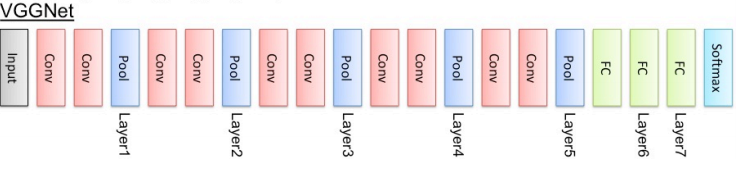
source:http://cs231n.stanford.edu/reports/2017/posters/931.pdf

This architecture give me great result, 18,82% on 1st epoch and 41% on 7th and also 41% accuracy on test data, but i can achieved it only via a lot of eperements.
First try was implement this architecture and start from conv(3:32).... til conv(256,256), with **adam optimizer, lr=1e-4**, and **drop out(0.3)** , but this method didt converge well, cand cope 35% level, after that I decided start from conv(3:64)...till conv(512,512), with the same **Adam** and **drop out(0.5)** this net shows the best params. 

**Adam** was choosen beacuse with it , result converges more faster, but when I stay **lr=1e-2** results were awful, as I think, this beause Adam just skip min, thats why I used **1e-4**, **Drop out(0.5)** also improve results

So, what I understood 

1) To choose right architecture for NN, not trivial task

2) Batch normalization improve results

3) Correct Dropout improve results very well

4) bigger lerning rate in Adam optimizer not always works well

5) It is really like a lego constructor 

